# An Approach To LOD (Hands-On)


## SETUP NOTEBOOK (execute only once)

### SETUP STEP 1 (execute only once)
First we need to tell Google Colab which Python packages we will need:

In [ ]:
# install all (external) packages
%%capture
!pip install qwikidata
!pip install lxml
!pip install jsonpath_ng

### SETUP STEP 2 (execute only once)
This is what we will insert before and after our triples. It's part of the SPARQL query and give us some additional fields (if available), like the GND ID or certain labels. But we don't need to look into this right now and we will execute this only once.

* Properties: GND ID, VIAF ID,
* Labels: English, German, French, Italian, Portuguese

In [ ]:
# this defines the columns/fields we will see later
sparql_query_prefix = """SELECT DISTINCT ?item ?gnd_id ?viaf_id ?label_en ?label_de ?label_fr ?label_it ?label_pt (year(?birth_date) as ?birth_year) (year(?death_date) as ?death_year)
WHERE
{
  """
# this is the counterpart of the above and adds some OPTIONAL triples that give us the values IF they are there, but they don't act as selectors
sparql_query_suffix = """
  OPTIONAL {?item wdt:P227 ?gnd_id.}
  OPTIONAL {?item wdt:P214 ?viaf_id.}
  OPTIONAL {?item wdt:P569 ?birth_date.}
  OPTIONAL {?item wdt:P570 ?death_date.}
  OPTIONAL {?item rdfs:label ?label_en filter (lang(?label_en) = "en").}
  OPTIONAL {?item rdfs:label ?label_de filter (lang(?label_de) = "de").}
  OPTIONAL {?item rdfs:label ?label_fr filter (lang(?label_fr) = "fr").}
  OPTIONAL {?item rdfs:label ?label_it filter (lang(?label_it) = "it").}
  OPTIONAL {?item rdfs:label ?label_pt filter (lang(?label_pt) = "pt").}
}"""

### SETUP STEP 3 (execute only once)
This contains some pre-defined functions we will use.
The code itself is not important for us, so it's stored away.

In [ ]:
import itertools
import requests
import json
from jsonpath_ng import jsonpath, parse
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

def refine_items(items_list):

  print("do refine wikidata exports, e.g. convert URIs into Qs")
  rowcount = 0
  wikidata_id = ''

  interimlist = []
  items_without_labels = []

  for row in items_list:
      rowcount = rowcount + 1 # starting at row 1
      if rowcount > 1:
          # we skipped row 1 (headers)
          wikidata_id = 'Q' + str(row['item']['value'].split('Q', 1)[1]) # reconstruct Wikidata ID
          # thw following is to make sure we either get data or an empty field:
          if('gnd_id' in row):
              gnd_id = row['gnd_id']['value']
          else:
              gnd_id = ''
          if('viaf_id' in row):
              viaf_id = row['viaf_id']['value']
          else:
              viaf_id = ''
          if('label_en' in row):
              label_en = row['label_en']['value']
          else:
              label_en = ''
          if('label_de' in row):
              label_de = row['label_de']['value']
          else:
              label_de = ''
          if('label_fr' in row):
              label_fr = row['label_fr']['value']
          else:
              label_fr = ''
          if('label_it' in row):
              label_it = row['label_it']['value']
          else:
              label_it = ''
          if('label_pt' in row):
              label_pt = row['label_pt']['value']
          else:
              label_pt = ''
          if('birth_year' in row):
              birth_year = row['birth_year']['value']
          else:
              birth_year = ''
          if('death_year' in row):
              death_year = row['death_year']['value']
          else:
              death_year = ''
          # human philosophers without any de/en/fr/it/pt label are excluded
          if(not(label_en == '' and label_de == '' and label_fr == '' and label_it == '' and label_pt == '')):
              # put those with some label in a list
              interimlist.append([wikidata_id, gnd_id, viaf_id, label_en, label_de, label_fr, label_it, label_pt, birth_year, death_year])
          else:
              # remember those items without labels for later
              items_without_labels.append(wikidata_id)

  # sort list
  interimlist.sort()

  # deduplicate (on all fields)
  deduplicatedlist = list(interimlist for interimlist,_ in itertools.groupby(interimlist))

  # append only first appearance of wikidata_id to new list (i.e. drop the duplicates)
  beenThere = set()
  simplifiedlist = []
  for row in deduplicatedlist:
      if row[0] not in beenThere:
          simplifiedlist.append(row)
          beenThere.add(row[0])


  # ### ### ### write csv (this is for those of you, who might use the code locally - mind to adjust the file path)
  """
  with open('../data/Wikidata_HumanPhilosophers_refined.csv', 'w', newline='') as csvfile_out:
      writer = csv.writer(csvfile_out)
      field = ['wikidata_id', 'gnd_id', 'viaf_id', 'label_en', 'label_de', 'label_fr', 'label_it', 'label_pt', 'birth_date', 'death_date']
      writer.writerow(field)
      for row in simplifiedlist:
          writer.writerow([row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7], row[8], row[9]])
  """

  print('The first 10 entries are:')
  listcount = 0
  for row in simplifiedlist:
      listcount = listcount + 1
      if(listcount <= 10):
          print(row)

  print('')
  print('Input: ' + str(rowcount))
  print('Output: ' + str(listcount))

  #data = simplifiedlist
  # dump dataset as JSON file
  #with open('entities.json', 'w', encoding='utf-8') as f:
  #    json.dump(data, f, ensure_ascii=False, indent=4)

  # make a nice markdown-list of the items without (en, de, fr, it, pt) labels:
  printable_md_items_without_labels = ""
  if len(items_without_labels)>0:
      for i in items_without_labels:
          printable_md_items_without_labels = printable_md_items_without_labels + "- [" + i + "]" + "(" + "https://www.wikidata.org/wiki/" + i + ")" + f"\n"

  printable_md_items_without_labels = (printable_md_items_without_labels)

  print('')
  print('List of entities without labels:')
  print(printable_md_items_without_labels)
  items_clean = (simplifiedlist)

  return items_clean

def request_wikidata_json(wikidata_id):
  url = 'https://www.wikidata.org/wiki/Special:EntityData/' + wikidata_id + '.json'

  #print('')
  #print('About to query: ' + url)
  request_response = requests.get(url, timeout=5)
  if request_response.status_code == 200:
    #print('HTTP request successful')
    return request_response.json()
  else:
    print('HTTP request returned error:')
    print(request_response.status_code)
    print(request_response)

def request_gnd_json(gnd_id):
  url = 'https://lobid.org/gnd/' + gnd_id + '.json'

  #print('')
  #print('About to query: ' + url)
  request_response = requests.get(url, timeout=5)
  if request_response.status_code == 200:
    #print('HTTP request successful')
    return request_response.json()
  else:
    print('HTTP request returned error:')
    print(request_response.status_code)
    print(request_response)

def get_wikidata_property_value(wikidata_json, property_id):
  property_path = '$.entities.*.claims.' + property_id + '.[0].mainsnak.datavalue.value'
  property_result = parse(property_path).find(wikidata_json)
  if len(property_result)>0:
    property_result_value = property_result[0].value
  else:
    #print('Cannot find ' + property_id + ' in wikidata_json!')
    property_result_value = None
  return property_result_value

def get_property_value_by_path(data_json, path):
  property_path = path
  property_result = parse(property_path).find(data_json)
  if len(property_result)>0:
    property_result_value = property_result[0].value
  else:
    #print('Cannot find ' + path + ' in data_json!')
    property_result_value = None
  return property_result_value

def merge_properties(wikidata_id, property_names, wikidata_properties, gnd_properties, wikidata_priority, gnd_priority):
  merged_properties = {}

  for property_name in property_names:
    if(gnd_priority > wikidata_priority):
      # prioritise GND:
      if property_name in gnd_properties:
        # found property in GND:
        merged_properties[property_name] = {'value': gnd_properties[property_name], 'origin': 'GND'}
      elif property_name in wikidata_properties:
        # couldn't find property in GND
        # but found property in Wikidata:
        merged_properties[property_name] = {'value': wikidata_properties[property_name], 'origin': 'Wikidata'}
      else:
        # couldn't find property at all:
        merged_properties[property_name] = {'value': '0000', 'origin': 'found_none'} # this is just a dummy value
    else:
      # prioritise Wikidata:
      if property_name in wikidata_properties:
        # found property in Wikidata:
        merged_properties[property_name] = {'value': wikidata_properties[property_name], 'origin': 'GND'}
      elif property_name in gnd_properties:
        # couldn't find property in Wikidata
        # but found property in GND:
        merged_properties[property_name] = {'value': gnd_properties[property_name], 'origin': 'Wikidata'}
      else:
        # couldn't find property at all:
        merged_properties[property_name] = {'value': '0000', 'origin': 'found_none'} # this is just a dummy value

  return {'wikidata_id': wikidata_id, 'properties': merged_properties}

def merge_properties_flat(wikidata_id, property_names, wikidata_properties, gnd_properties, wikidata_priority, gnd_priority):
  """ this will give merged_properties without origins as a flat dictionary - as a basis for e.g. csv export """
  # first do merge_properties
  merged_properties = merge_properties(wikidata_id, property_names, wikidata_properties, gnd_properties, wikidata_priority, gnd_priority)

  # now flatten it by only taking the values and dropping the origins
  merged_properties_flat = {}
  merged_properties_flat['wikidata_id'] = merged_properties['wikidata_id']
  for prop_name, prop_content in merged_properties['properties'].items():
    merged_properties_flat[prop_name] = prop_content['value']
  return merged_properties_flat


def show_simple_timeline(dates, names):
  """ dates as list of YYYY-MM-DD strings, names as list of strings """
  # put it in a dataframe
  df = pd.DataFrame({'date': pd.to_datetime(dates), 'name': names})

  #print(df) # (print dataframe to check dates/names)

  # sort by date
  df.sort_values('date', inplace=True)
  df.reset_index(drop=True, inplace=True)

  # create plot
  fig, ax = plt.subplots(figsize=(14, 6))

  # horizontal line
  ax.hlines(0, df['date'].min() - pd.Timedelta(days=500), df['date'].max() + pd.Timedelta(days=500), color='grey', linewidth=1)

  # plot events (dates)
  ax.scatter(df['date'], [0]*len(df), color='darkblue', s=100, zorder=3)

  # avoid overlaps by
  y_positions = np.zeros(len(df))
  label_offsets = []

  # minimum distance betweens labels (on Y-axis)
  min_y_gap = 0.3

  for i in range(len(df)):
      y = min_y_gap
      # check for other labels that are nearby
      for j in range(i):
          time_diff = abs((df.loc[i, 'date'] - df.loc[j, 'date']).days)
          if time_diff < 500:  # if < 500 days away
              if abs(y_positions[j] - y) < min_y_gap:
                  y += min_y_gap
      y_positions[i] = y

  # put labels/names according to events/dates
  for idx in range(len(df)):
      x = df.loc[idx, 'date']
      y = y_positions[idx]
      ax.plot([x, x], [0, y], color='grey', linewidth=1, linestyle='--')
      #ax.text(x, y, df.loc[idx, 'name'], rotation=45, fontsize=9, ha='right', va='bottom')
      ax.text(x, y, df.loc[idx, 'name'], rotation=90, fontsize=9, ha='right', va='bottom')

  # X-axis formatting
  ax.xaxis.set_major_locator(mdates.YearLocator(10))  # Alle 10 Jahre
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
  plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
  #plt.setp(ax.get_xticklabels(), rotation=90, ha='right')

  # hide Y-axis & co
  ax.get_yaxis().set_visible(False)
  for spine in ['left', 'right', 'top']:
      ax.spines[spine].set_visible(False)

  #ax.set_title('birth_dates with preferred_names', fontsize=16)
  plt.tight_layout()
  plt.show()


### SETUP STEP 4 (execute only once)
This contains some pre-defined data.
You will find the mappings and the corresponding schema here.

### SETUP STEP 5 (execute only once) // nexus_py
This contains the "Nexus" (nexus_py.py) class and mappings. You will find this on GitHub, too.
There are still some rough edges and right now there is about no error handling.
* nexus_py: Does the workflow in a more sophisticated way and uses mappings to aggregate the data. Thus you may modify the desired output by customising the mappings. (=> modify existing mappings or add new mappings)
* mappings.json: Is used as a configuration for the aggregation process and the output.
* mappings_schema.json: Is used to validate the mappings.json against => defines the structure of mappings.json and helps to avoid errors.

#### Mappings-Schema JSON

In [ ]:
nexus_mappings_schema_json = """
{
    "$id": "https://example.com/nexus-mappings.schema.json",
    "$schema": "https://json-schema.org/draft/2020-12/schema",
    "description": "A list of mappings between prioritized sources towards a Nexus object",
    "type": "object",
    "properties": {
        "mappings": {
            "type": "array",
            "items": {
                "type": "object",
                "properties": {
                    "mappingProfile": {
                        "type": "string"
                    },
                    "mappingFields": {
                        "type": "array",
                        "items": {
                            "type": "object",
                            "properties": {
                                "fieldName": {
                                    "type": "string"
                                },
                                "fieldSources": {
                                    "type": "array",
                                    "items": {
                                        "type": "object",
                                        "properties": {
                                            "sourceName": {
                                                "type": "string"
                                            },
                                            "property": {
                                                "type": "string"
                                            },
                                            "fuzzyIsA": {
                                                "type": "array",
                                                "items": {
                                                    "type": "string"
                                                }
                                            },
                                            "pathInSource": {
                                                "type": "string"
                                            }
                                        },
                                        "required": ["sourceName", "property", "fuzzyIsA", "pathInSource"],
                                        "additionalProperties": false
                                    }
                                }
                            },
                            "required": ["fieldName", "fieldSources"],
                            "additionalProperties": false
                        }
                    },
                    "mappingSources": {
                        "type": "array",
                        "items": {
                            "type": "object",
                            "properties": {
                                "sourceName": {
                                    "type": "string"
                                },
                                "sourcePriority": {
                                    "type": "integer"
                                },
                                "sourcePrefix": {
                                    "type": "string"
                                },
                                "sourceSuffix": {
                                    "type": "string"
                                },
                                "sourceFormat": {
                                    "type": "string"
                                }
                            },
                            "required": ["sourceName", "sourcePriority", "sourcePrefix", "sourceSuffix", "sourceFormat"],
                            "additionalProperties": false
                        }
                    }
                },
                "required": ["mappingProfile", "mappingFields", "mappingSources"],
                "additionalProperties": false
            }
        }
    },
    "required": ["mappings"],
    "additionalProperties": false
}
"""

#### Mappings JSON

In [ ]:
nexus_mappings_json = """
{
    "mappings": [
        {
            "mappingProfile": "person",
            "mappingFields": [
                {
                    "fieldName": "wikidata_id",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "title",
                            "fuzzyIsA": [],
                            "pathInSource": "$.entities.*.title"
                        }
                    ]
                },
                {
                    "fieldName": "gnd_id",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P227",
                            "fuzzyIsA": [],
                            "pathInSource": "$.entities.*.claims.P227.[0].mainsnak.datavalue.value"
                        }
                    ]
                },
                {
                    "fieldName": "preferred_name",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "labels.en",
                            "fuzzyIsA": [],
                            "pathInSource": "$.entities.*.labels.en.value"
                        },
                        {
                            "sourceName": "GND",
                            "property": "preferredName",
                            "fuzzyIsA": [],
                            "pathInSource": "$.preferredName"
                        }
                    ]
                },
                {
                    "fieldName": "birth_date",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P569",
                            "fuzzyIsA": ["https://www.cidoc-crm.org/cidoc-crm/E52_Time-Span", "https://schema.org/birthDate", "https://schema.org/Date"],
                            "pathInSource": "$.entities.*.claims.P569.[0].mainsnak.datavalue.value.time"
                        },
                        {
                            "sourceName": "GND",
                            "property": "dateOfBirth",
                            "fuzzyIsA": ["https://www.cidoc-crm.org/cidoc-crm/E52_Time-Span", "https://schema.org/birthDate", "https://schema.org/Date"],
                            "pathInSource": "$.dateOfBirth.[0]"
                        },
                        {
                            "sourceName": "LCNAF",
                            "property": "http://www.loc.gov/mads/rdf/v1#birthDate",
                            "fuzzyIsA": ["https://www.cidoc-crm.org/cidoc-crm/E52_Time-Span", "https://schema.org/birthDate", "https://schema.org/Date"],
                            "pathInSource": "$.dateOfBirth"
                        },
                        {
                            "sourceName": "VIAF",
                            "property": "birthDate",
                            "fuzzyIsA": ["https://www.cidoc-crm.org/cidoc-crm/E52_Time-Span", "https://schema.org/birthDate", "https://schema.org/Date"],
                            "pathInSource": "/*[local-name()='RDF']/*[local-name()='Concept']/*[local-name()='focus']/*[local-name()='Person']/*[local-name()='birthDate']/text()"
                        }
                    ]
                },
                {
                    "fieldName": "birth_place",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P19",
                            "fuzzyIsA": ["https://schema.org/Place"],
                            "pathInSource": "$.entities.*.claims.P19.[0].mainsnak.datavalue.value.id"
                        },
                        {
                            "sourceName": "LCNAF",
                            "property": "placeOfBirth",
                            "fuzzyIsA": ["https://schema.org/Place"],
                            "pathInSource": "$.placeOfBirth"
                        },
                        {
                            "sourceName": "GND",
                            "property": "placeOfBirth",
                            "fuzzyIsA": ["https://schema.org/Place"],
                            "pathInSource": "$.placeOfBirth.[0].label"
                        }
                    ]
                },
                {
                    "fieldName": "death_date",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P570",
                            "fuzzyIsA": ["https://www.cidoc-crm.org/cidoc-crm/E52_Time-Span", "https://schema.org/deathDate", "https://schema.org/Date"],
                            "pathInSource": "$.entities.*.claims.P570.[0].mainsnak.datavalue.value.time"
                        },
                        {
                            "sourceName": "GND",
                            "property": "dateOfDeath",
                            "fuzzyIsA": ["https://www.cidoc-crm.org/cidoc-crm/E52_Time-Span", "https://schema.org/deathDate", "https://schema.org/Date"],
                            "pathInSource": "$.dateOfDeath.[0]"
                        },
                        {
                            "sourceName": "VIAF",
                            "property": "deathDate",
                            "fuzzyIsA": ["https://www.cidoc-crm.org/cidoc-crm/E52_Time-Span", "https://schema.org/deathDate", "https://schema.org/Date"],
                            "pathInSource": "/*[local-name()='RDF']/*[local-name()='Concept']/*[local-name()='focus']/*[local-name()='Person']/*[local-name()='deathDate']/text()"
                        }
                    ]
                },
                {
                    "fieldName": "death_place",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P20",
                            "fuzzyIsA": ["https://schema.org/Place"],
                            "pathInSource": "$.entities.*.claims.P20.[0].mainsnak.datavalue.value.id"
                        },
                        {
                            "sourceName": "GND",
                            "property": "placeOfDeath",
                            "fuzzyIsA": ["https://schema.org/Place"],
                            "pathInSource": "$.placeOfDeath.[0].label"
                        }
                    ]
                }
            ],
            "mappingSources": [
                {
                    "sourceName": "Wikidata",
                    "sourcePriority": 0,
                    "sourcePrefix": "https://www.wikidata.org/wiki/Special:EntityData/",
                    "sourceSuffix": ".json",
                    "sourceFormat": "json"
                },
                {
                    "sourceName": "GND",
                    "sourcePriority": 70,
                    "sourcePrefix": "https://lobid.org/gnd/",
                    "sourceSuffix": ".json",
                    "sourceFormat": "json"
                },
                {
                    "sourceName": "VIAF",
                    "sourcePriority": 90,
                    "sourcePrefix": "https://viaf.org/viaf/",
                    "sourceSuffix": "/rdf.xml",
                    "sourceFormat": "xml"
                }
                ,
                {
                    "sourceName": "LCNAF",
                    "sourcePriority": 100,
                    "sourcePrefix": "https://id.loc.gov/authorities/names/",
                    "sourceSuffix": ".json",
                    "sourceFormat": "json"
                }
            ]
        },
        {
            "mappingProfile": "work",
            "mappingFields": [
                {
                    "fieldName": "author",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P50",
                            "fuzzyIsA": [],
                            "pathInSource": "$.entities.*.claims.P50.[0].mainsnak.datavalue.value.id"
                        },
                        {
                            "sourceName": "GND",
                            "property": "firstAuthor",
                            "fuzzyIsA": [],
                            "pathInSource": "$.firstAuthor.[0].label"
                        },
                        {
                            "sourceName": "VIAF",
                            "property": "creator",
                            "fuzzyIsA": [],
                            "pathInSource": "/*[local-name()='RDF']/*[local-name()='Concept']/*[local-name()='focus']/*[local-name()='CreativeWork']/*[local-name()='creator']/*[local-name()='Agent']/*[local-name()='label']/text()"
                        }
                    ]
                },
                {
                    "fieldName": "full_work_at",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P953",
                            "fuzzyIsA": [],
                            "pathInSource": "$.entities.*.claims.P953.[0].mainsnak.datavalue.value"
                        }
                    ]
                }
            ],
            "mappingSources": [
                {
                    "sourceName": "Wikidata",
                    "sourcePriority": 0,
                    "sourcePrefix": "https://www.wikidata.org/wiki/Special:EntityData/",
                    "sourceSuffix": ".json",
                    "sourceFormat": "json"
                },
                {
                    "sourceName": "GND",
                    "sourcePriority": 40,
                    "sourcePrefix": "https://lobid.org/gnd/",
                    "sourceSuffix": ".json",
                    "sourceFormat": "json"
                },
                {
                    "sourceName": "VIAF",
                    "sourcePriority": 50,
                    "sourcePrefix": "https://viaf.org/viaf/",
                    "sourceSuffix": "/rdf.xml",
                    "sourceFormat": "xml"
                }
            ]
        },
        {
            "mappingProfile": "wikidata_to_authorities",
            "mappingFields": [
                {
                    "fieldName": "GND",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P227",
                            "fuzzyIsA": [],
                            "pathInSource": "$.entities.*.claims.P227.[0].mainsnak.datavalue.value"
                        }
                    ]
                },
                {
                    "fieldName": "VIAF",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P214",
                            "fuzzyIsA": [],
                            "pathInSource": "$.entities.*.claims.P214.[0].mainsnak.datavalue.value"
                        }
                    ]
                },
                {
                    "fieldName": "LCNAF",
                    "fieldSources": [
                        {
                            "sourceName": "Wikidata",
                            "property": "P244",
                            "fuzzyIsA": [],
                            "pathInSource": "$.entities.*.claims.P244.[0].mainsnak.datavalue.value"
                        }
                    ]
                }
            ],
            "mappingSources": [
                {
                    "sourceName": "Wikidata",
                    "sourcePriority": 100,
                    "sourcePrefix": "https://www.wikidata.org/wiki/Special:EntityData/",
                    "sourceSuffix": ".json",
                    "sourceFormat": "json"
                }
            ]
        }
    ]
}
"""

#### nexus_py (WIP)

In [ ]:
""" module manages querying/requesting LOD sources and factlet creation """

import json
#import xml.etree.ElementTree.parse as parse_xml
#import xml.etree.ElementTree as ET
import requests
from jsonpath_ng import jsonpath
#from jsonpath_ng.ext.parse import parse_json # cf. https://github.com/h2non/jsonpath-ng/issues/8 (16.10.2024)
from jsonpath_ng.ext import parse
import time
from jsonschema import validate, ValidationError
#from selenium import webdriver
#from selenium.webdriver.common.by import By
from lxml import etree
import re
import pandas


class Factlet:
    """ content + context """
    #
    # cf. https://graphentechnologien.hypotheses.org/files/2021/02/Thaller-Mainz2021-2.pdf
    # => "Tokens taken from sources are data. Provisionally interpreted they become information. A token together with the data needed for its interpretation is called a factlet." (p2)
    # => "Note: Tokens can be texts – and will be frequently so – are not required to be so." (p2)

    def __init__(self):
        _name = None                # the factlet's/field's name, try to make it self-explaining
        _description = None         # a short description
        _value = None               # the actual value/content
        _timestamp = None           # time of factlet creation
        _fuzzy_isA = None           # corresponding classes in different ontologies
        _subject = None             # entity that is described by the factlet (Wikidata- or GND-ID of described entity)
        _source = None              # source of factlet (should be an URI?!)
        _source_property = None     # specifies the corresponding property in source
        _source_date = None         # date of lastRevision or similar
        _source_path = None         # path in source to given data (XPATH/JSONPath/...)
        _source_licence = None      # licence for the data declared by the source

    # def __init__(self, value, timestamp, fuzzy_isA, subject, source, source_property, source_date, source_path, source_licence):
    #     self._value = value
    #     self._timestamp = timestamp
    #     self._fuzzy_isA = fuzzy_isA
    #     self._subject = subject
    #     self._source = source
    #     self._source_property = source_property
    #     self._source_date = source_date
    #     self._source_path = source_path
    #     self._source_licence = source_licence

    def set_name(self, name):
        self._name = name

    def get_name(self):
        return self._name

    def set_description(self, description):
        self._description = description

    def get_description(self):
        return self._description

    def set_value(self, value):
        self._value = value

    def get_value(self):
        return self._value

    def set_timestamp(self, timestamp):
        self._timestamp = timestamp

    def get_timestamp(self):
        return self._timestamp

    def set_fuzzy_isA(self, fuzzy_isA):
        self._fuzzy_isA = fuzzy_isA

    def get_fuzzy_isA(self):
        return self._fuzzy_isA

    def set_subject(self, subject):
        self._subject = subject

    def get_subject(self):
        return self._subject

    def set_source(self, source):
        self._source = source

    def get_source(self):
        return self._source

    def set_source_property(self, source_property):
        self._source_property = source_property

    def get_source_property(self):
        return self._source_property

    def set_source_date(self, source_date):
        self._source_date = source_date

    def get_source_date(self):
        return self._source_date

    def set_source_path(self, source_path):
        self._source_path = source_path

    def get_source_path(self):
        return self._source_path

    def set_source_licence(self, source_licence):
        self._source_licence = source_licence

    def get_source_licence(self):
        return self._source_licence

    def get_as_dict(self):
        """ returns the whole factlet as a dictionary """
        factlet_dict = {'name': self._name,
                        'description': self._description,
                        'value': self._value,
                        'timestamp': self._timestamp,
                        'fuzzy_isA': self._fuzzy_isA,
                        'subject': self._subject,
                        'source': self._source,
                        'source_property': self._source_property,
                        'source_date': self._source_date,
                        'source_path': self._source_path
                        }
        return factlet_dict

class Nexus:
    """ ... """

    def __init__(self):
        self._wikidata_id = None
        self._data = None
        self._request_response = {}
        self._gnd_response = None
        self._gnd_id = None
        self._mappings = None
        self._mappings_schema = None
        self._mapping_profile = None
        self._fields = []
        self._sources = []
        self._source_ranking = []
        self._source_formats = {}
        self._identifiers = {}

    def data_fallback(self, field_object, source_ranking, current_source = 0):
        """ recursive iteration through source_ranking returns available field of highest priority """
        if current_source < len(source_ranking):
            found = None
            for s in field_object['fieldSources']:
                if s['sourceName'] == source_ranking[current_source]:
                    found = s
                    break
            else:
                found = None

            if found is not None:
                field_value = None
                match self._source_formats[source_ranking[current_source]]:
                    case 'json':
                        if source_ranking[current_source] in self._request_response:
                            field_value = self.resolve_jsonpath(found['pathInSource'],self._request_response[source_ranking[current_source]]['response'])
                        else:
                            #print(source_ranking[current_source] + ' without request response')
                            """ """
                    case 'xml':
                        if source_ranking[current_source] in self._request_response:
                        #print('trying to resolve a path of a format (' + self._source_formats[source_ranking[current_source]] +') that is not supported')
                            field_value = self.resolve_xpath(found['pathInSource'],self._request_response[source_ranking[current_source]]['response'])
                        else:
                            #print(source_ranking[current_source] + ' without request response')
                            """ """
                    case _:
                        print('trying to resolve a path of a format (' + self._source_formats[source_ranking[current_source]] +') that is not supported')

                if field_value is not None:
                    # found something in that field => create factlet:
                    #print(source_ranking[current_source] + ': ' + str(field_value))
                    new_factlet = Factlet()
                    new_factlet.set_name(field_object['fieldName'])
                    new_factlet.set_description('...')
                    new_factlet.set_value(field_value)
                    new_factlet.set_timestamp(time.time())
                    new_factlet.set_fuzzy_isA(found['fuzzyIsA'])
                    new_factlet.set_subject(self._identifiers)
                    new_factlet.set_source(found['sourceName'])
                    new_factlet.set_source_date('')
                    new_factlet.set_source_path(found['pathInSource'])
                    new_factlet.set_source_property(found['property'])
                    new_factlet.set_source_licence('')
                    return new_factlet.get_as_dict()
                else:
                    return self.data_fallback(field_object, source_ranking, current_source + 1)
            else:
                return self.data_fallback(field_object, source_ranking, current_source + 1)
        else:
            return None

    def aggregate(self):
        """ aggregates the different sources according to nexus_mappings.json """
        fields = self.resolve_jsonpath('$.*[?(@.mappingProfile == "' + self._mapping_profile +'")].mappingFields', self._mappings)
        sources = self.resolve_jsonpath('$.*[?(@.mappingProfile == "' + self._mapping_profile +'")].mappingSources', self._mappings)

        sources = sorted(sources, key=lambda item: item['sourcePriority'], reverse=True) # sort list by sourcePriority (which is rated 0 to 100), descending

        #responses = []

        for k, v in self._identifiers.items():
            #print('')
            for s in sources:
                if s['sourceName'] == k:
                    #print('request ' + v + ' from ' + k)
                    self.request(k, v)
                    if k in self._request_response:
                        #print(k + ' delivered data')
                        """ """
                    else:
                        print('requesting ' + k + ' did not succeed')
                    break
            else:
                s = None
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
                print('identifier for ' + k + ' was given, but couldnt be found in nexus_mappings.json')
                print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')

        #print('')
        #print('### ### ### ###')
        #print('### fields ###')
        for field in fields:
            #print(field)
            #print('new_factlet:')
            #print(field['fieldName'])
            #print(self._source_ranking)
            new_factlet = self.data_fallback(field, self._source_ranking, 0)
            #print(new_factlet)
            if new_factlet is not None:
                self._fields.append(new_factlet)
            #print('---')
        #print('### ### ### ###')
        #print('### ### ### ###')

    def set_identifier(self, source_name, identifier):
        self._identifiers[source_name] = identifier

    def get_identifier(self, source_name):
        return self._identifiers[source_name]

    def set_identifiers(self, dict_identifiers):
        self._identifiers = self._identifiers | dict_identifiers # merge dictionaries and update existing keys with dict_identifiers values

    def get_mapping_profile(self):
        return self._mapping_profile

    def get_request_response(self, source_name):
        return self._request_response[source_name]['response']

    def set_mappings_json(self, mappings_json, mappings_schema_json):
        self._mappings = mappings_json
        self._mappings_schema = mappings_schema_json

    def set_mapping_profile(self, mapping_profile):
        self._mapping_profile = mapping_profile

    def mappings_json_is_valid(self):
        #print('### ### ### ### ### ### ### ### ###')
        #print('### nexus_mappings.json validation ###')
        #print('### ### ### ### ### ### ### ### ###')

        if self._mappings is not None and self._mappings_schema is not None:
            # validate mapping against its schema:
            try:
                validate(instance=self._mappings, schema=self._mappings_schema)
                #print('nexus_mappings_json is valid')
                return True
            except ValidationError as e:
                print(e.message)
                print('nexus_mappings_json is not valid')
                return False
        else:
            print('error: mappings not set')
            return False

        #print('### ### ### ### ### ### ### ### ###')
        #print('### /nexus_mappings.json validation ###')
        #print('### ### ### ### ### ### ### ### ###')



    def load_sources(self):
        sources = self.resolve_jsonpath('$.*[?(@.mappingProfile == "' + self._mapping_profile +'")].mappingSources', self._mappings)
        #print('### ### ### ###')
        #print('### sources ###')
        sources = sorted(sources, key=lambda item: item['sourcePriority'], reverse=True) # sort list by sourcePriority (which is rated 0 to 100), descending
        for source in sources:
            #print(source)
            #print(source['sourceName'])
            self._source_ranking.append(source['sourceName'])
            self._source_formats[source['sourceName']] = source['sourceFormat']
            #print('---')
        #print('### ### ### ###')
        #print('### ### ### ###')


    def resolve_xpath(self, find_xpath, in_source):
        """ resolve xpath and return first value """
        xpath_result = in_source.xpath(find_xpath)
        if len(xpath_result)>0:
            #xpath_result_return = xpath_result[0].value
            xpath_result_return = str(xpath_result[0])
        else:
            xpath_result_return = None # ?
        return xpath_result_return

    def resolve_jsonpath(self, find_jsonpath, in_source):
        """ resolve jsonpath and return first value """
        jsonpath_result = parse(find_jsonpath).find(in_source)

        if len(jsonpath_result)>0:
            jsonpath_result_return = jsonpath_result[0].value
        else:
            jsonpath_result_return = None # ?
        return jsonpath_result_return

    def request(self, source_name, source_item_id):
        """ make HTTP request for the nexus entity """

        source_prefix = self.resolve_jsonpath('$.*[?(@.mappingProfile == "' + self._mapping_profile +'")].mappingSources[?(@.sourceName == "' + source_name +'")].sourcePrefix', self._mappings)
        source_suffix = self.resolve_jsonpath('$.*[?(@.mappingProfile == "' + self._mapping_profile +'")].mappingSources[?(@.sourceName == "' + source_name +'")].sourceSuffix', self._mappings)
        source_format = self.resolve_jsonpath('$.*[?(@.mappingProfile == "' + self._mapping_profile +'")].mappingSources[?(@.sourceName == "' + source_name +'")].sourceFormat', self._mappings)

        url = source_prefix + str(source_item_id) + source_suffix # NOTE: this doesn't make sense as it is rn => IDs should also be dependent on mapping (of sources)...

        #print('going to query url=' + url)
        request_response = requests.get(url, timeout=3)
        #request_response = requests.get(url, timeout=10)
        if request_response.status_code == 200:
            match self._source_formats[source_name]:
                case 'json':
                    self._request_response[source_name] = {'response': request_response.json(), 'format': source_format}
                case 'xml':
                    response_text = request_response.text
                    cleaned_text = response_text.replace('\n', '') # NOTE: might be only for VIAF...
                    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip() # NOTE: might be only for VIAF...
                    self._request_response[source_name] = {'response': etree.fromstring(cleaned_text), 'format': source_format}
                case _:
                    print('trying to convert a request response with a format (' + self._source_formats[source_name] +') that is not supported')
        else:
            print('HTTP request returned error:')
            print(request_response.status_code)
            print(request_response)

    # def do_things(self):
    #     """ ... """

    #     self.load_sources()

    #     print('------------------------------------')
    #     print('------------------------------------')
    #     print('------------------------------------')
    #     for s in self._sources:
    #         print(s['sourceName'])
    #         if(s['sourceName'] in self._identifiers):
    #             print(s['sourceName'] + ': ' + self._identifiers[s['sourceName']])

    #     self.aggregate()

    #     print('about the ' + self._mapping_profile + ' you requested...')
    #     for field in self._fields:
    #         #print(field.get_name())
    #         if field is not None:
    #             print(field.get_name() + ': ' + field.get_value() + ' // via ' + field.get_source() + '.' + field.get_source_property() + '(' + field.get_source_path() + ')')

    def get_aggregation(self, mappings_json, mappings_schema_json, mapping_profile, dict_identifiers):
        self.set_mappings_json(mappings_json, mappings_schema_json)
        self.set_mapping_profile(mapping_profile)
        self.set_identifiers(dict_identifiers)
        if self.mappings_json_is_valid():
            #self.do_things()
            self.load_sources()
            # for s in self._sources:
            #     print(s['sourceName'])
            #     if(s['sourceName'] in self._identifiers):
            #         print(s['sourceName'] + ': ' + self._identifiers[s['sourceName']])

            self.aggregate()
            return self._fields

    def get_aggregation_flat(self, mappings_json, mappings_schema_json, mapping_profile, dict_identifiers):
        """ return a flat version of get_aggregate without context/provenance data """
        aggregated_fields = self.get_aggregation(mappings_json, mappings_schema_json, mapping_profile, dict_identifiers)
        aggregation_flat = {}
        for f in aggregated_fields:
            aggregation_flat[f['name']] = f['value']
        return aggregation_flat


    def get_aggregation_json(self, mappings_json, mappings_schema_json, mapping_profile, dict_identifiers):
        """ return a JSON version of get_aggregate """
        aggregated_fields = self.get_aggregation(mappings_json, mappings_schema_json, mapping_profile, dict_identifiers)
        aggregation_json = json.dumps(aggregated_fields)
        return aggregation_json

## WORKFLOW 1 (Wikidata + GND)

1. query Wikidata with SPARQL
2. get detailed data from Wikidata
3. get detailed data from GND
4. merge data by priority
5. do 2, 3, 4 for all our items
6. visualise data
7. download data

### STEP 1 (!): SPARQL + refinement (define our set of items/entities)

We can build our SPARQL query in the [Wikidata Query Service](https://query.wikidata.org/) and then copy & paste the triples into our code cell below.
Use https://www.wikidata.org to look for properties and entities you would like to use.

#### Cheat Sheet:


* some examples for occupations (P106):
  * philosopher: Q4964182
  * chemist: Q593644
  * writer: Q36180

* the parts of this example:
  * is a human: wdt:P31 wd:Q5
  * occupation is philosopher: wdt:P106 wd:Q4964182
  * has a PhD: wdt:P512 wd:Q752297
  * has a link to the GND: wdt:P227 ?gnd_id

#### STEP 1.1 (!): Let's define our triples:
* should start with "?item" as our subject
* each element should be delimited by a blank space
* should end with a "." (dot)
* each predicate + object pair (but the first) has to be appended with a ";" (semicolon)

In [ ]:
sparql_query_triples = "?item wdt:P31 wd:Q5 ; wdt:P106 wd:Q4964182 ; wdt:P512 wd:Q752297 ; wdt:P227 ?gnd_id ."

# put it all together
sparql_query = sparql_query_prefix + sparql_query_triples + sparql_query_suffix

# check if the query looks as intended
print(sparql_query)

SELECT DISTINCT ?item ?gnd_id ?viaf_id ?label_en ?label_de ?label_fr ?label_it ?label_pt (year(?birth_date) as ?birth_year) (year(?death_date) as ?death_year)
WHERE
{
  ?item wdt:P31 wd:Q5 ; wdt:P106 wd:Q4964182 ; wdt:P512 wd:Q752297 ; wdt:P227 ?gnd_id .
  OPTIONAL {?item wdt:P227 ?gnd_id.}
  OPTIONAL {?item wdt:P214 ?viaf_id.}
  OPTIONAL {?item wdt:P569 ?birth_date.}
  OPTIONAL {?item wdt:P570 ?death_date.}
  OPTIONAL {?item rdfs:label ?label_en filter (lang(?label_en) = "en").}
  OPTIONAL {?item rdfs:label ?label_de filter (lang(?label_de) = "de").}
  OPTIONAL {?item rdfs:label ?label_fr filter (lang(?label_fr) = "fr").}
  OPTIONAL {?item rdfs:label ?label_it filter (lang(?label_it) = "it").}
  OPTIONAL {?item rdfs:label ?label_pt filter (lang(?label_pt) = "pt").}
}


#### STEP 1.2 (!): Send query to Wikidata and count returned items
This does the HTTP request for us using our SPARQL query and gives us a short feedback (shows count of returned items).

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('send SPARQL query to Wikidata...(and get all humans who are occupied as philosopher and have a PhD)')
print('### ### ### ### ### ### ### ### ### ###')
from qwikidata.sparql import (get_subclasses_of_item, return_sparql_query_results)
import urllib.request, json

def fetch_entities_from_wikidata():
# does the HTTP request and returns query response (in a nice way)
    return return_sparql_query_results(sparql_query)

# make bindings (i.e. wanted results of the query) available in other code cells
items = (fetch_entities_from_wikidata()["results"]["bindings"])
print('Items count: ' + str(len(items)))

### ### ### ### ### ### ### ### ### ###
send SPARQL query to Wikidata...(and get all humans who are occupied as philosopher and have a PhD)
### ### ### ### ### ### ### ### ### ###
Items count: 450


#### STEP 1.3: Get a more detailed feedback by highlighting a random item.

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('choose a random item...')
print('### ### ### ### ### ### ### ### ### ###')

import random

print('items count: ' + str(len(items)))
randomItemNr = random.randint(0, len(items)-1) # get random number within scope
print('Random item (' + str(randomItemNr) + '):')
print(items[randomItemNr])
randomItem = items[randomItemNr] # get random entity
if 'label_en' in randomItem:
  print(randomItem['item']['value'].split('/')[-1] + ' = ' + randomItem['label_en']['value'])

# make entity's Wikidata ID available in other code cells
randomItemQID = (randomItem['item']['value'].split('/')[-1])


### ### ### ### ### ### ### ### ### ###
choose a random item...
### ### ### ### ### ### ### ### ### ###
items count: 450
Random item (266):
{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q111686700'}, 'label_en': {'xml:lang': 'en', 'type': 'literal', 'value': 'John Taylor'}, 'gnd_id': {'type': 'literal', 'value': '173019110'}, 'viaf_id': {'type': 'literal', 'value': '50542016'}, 'birth_year': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '1915'}, 'death_year': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '1996'}}
Q111686700 = John Taylor


#### STEP 1.4 (!): Refinement and deduplication (execute after each new query)
This will clean up our set of items.
* Throw out items without en, de, fr, it, pt labels
* Pick only the first appearance of an items (deduplication)

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('do some refinement on the list of items...(deduplication and sorting out entities without labels...)')
print('### ### ### ### ### ### ### ### ### ###')

items_cleaned = refine_items(items)

### ### ### ### ### ### ### ### ### ###
do some refinement on the list of items...(deduplication and sorting out entities without labels...)
### ### ### ### ### ### ### ### ### ###
do refine wikidata exports, e.g. convert URIs into Qs
The first 10 entries are:
['Q100428034', '1221604929', '11158912149049770336', 'Elisabeth Paquette', 'Elisabeth Paquette', 'Elisabeth Paquette', 'Elisabeth Paquette', 'Elisabeth Paquette', '', '']
['Q100699312', '1190767597', '317108092', 'Andrea J. Pitts', '', '', 'Andrea J. Pitts', '', '', '']
['Q100745230', '1103835785', '28870973', 'Eddy Souffrant', '', '', '', '', '', '']
['Q102246200', '1014901588', '176876582', 'Heinrich Leonhard', 'Heinrich Leonhard', '', '', '', '1854', '1942']
['Q104813936', '114574065', '433159474351027662917', 'Alexander Wiehart', 'Alexander Wiehart', 'Alexander Wiehart', 'Alexander Wiehart', '', '', '']
['Q105243708', '151537305', '32050061', 'Robert Nola', 'Robert Nola', 'Robert Nola', '', '', '1940', '2022']
['Q105274874', 

#### STEP 1.5: Get a more detailed feedback by highlighting a random item again.
(You can click the links to look it up in Wikidata or the GND Explorer.)

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('choose a random item...again')
print('### ### ### ### ### ### ### ### ### ###')

import random

print('Items count: ' + str(len(items_cleaned)))
randomItemNr = random.randint(0, len(items_cleaned)-1) # get random number within scope
print('Random item (' + str(randomItemNr) + '):')
print(items_cleaned[randomItemNr])
randomItem = items_cleaned[randomItemNr] # get random entity

# make entity's Wikidata ID available in other code cells
randomItemQID = (randomItem[0])
print('Wikidata-ID: ' + randomItemQID + ' (cf. Wikidata: https://www.wikidata.org/wiki/Special:EntityData/' + randomItemQID + ')')

# make entity's Wikidata ID available in other code cells
randomItemGNDID = (randomItem[1])
print('GND-ID: ' + randomItemGNDID + ' (cf. GND Explorer: https://explore.gnd.network/gnd/' + randomItemGNDID + ')')

### ### ### ### ### ### ### ### ### ###
choose a random item...again
### ### ### ### ### ### ### ### ### ###
Items count: 422
Random item (101):
['Q16664965', '12166371X', '24653124', 'John M. Cooper', 'John Madison Cooper', 'John M. Cooper', 'John M. Cooper', 'John M. Cooper', '1939', '2022']
Wikidata-ID: Q16664965 (cf. Wikidata: https://www.wikidata.org/wiki/Special:EntityData/Q16664965)
GND-ID: 12166371X (cf. GND Explorer: https://explore.gnd.network/gnd/12166371X)


### STEP 2 (! DIY): **Wikidata** => get data for randomItemQID (execute after each new query)

#### STEP 2.0 (DIY): set randomItemQID yourself (OPTIONAL)
Set an ID of an entity you know well => for evaluation of the returned data.

In [ ]:
# set randomItemQID yourself (instead of a random item):
randomItemQID = "Q173481" # e.g. Fernando Pessoa = Q173481
#randomItemQID = "Q859" # e.g. Plato = Q859

print('### ### ### ### ### ### ### ### ### ###')
print('randomItemQID is set to ' + randomItemQID + ' (cf. Wikidata: https://www.wikidata.org/wiki/Special:EntityData/' + randomItemQID + ')')
print('### ### ### ### ### ### ### ### ### ###')

### ### ### ### ### ### ### ### ### ###
randomItemQID is set to Q173481 (cf. Wikidata: https://www.wikidata.org/wiki/Special:EntityData/Q173481)
### ### ### ### ### ### ### ### ### ###


#### STEP 5.1: use randomItemQID to request entity data via Wikidata's Linked Data Interface

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('send HTTP request for ' + randomItemQID + ' to Wikidata and get data as JSON...')
print('### ### ### ### ### ### ### ### ### ###')

wikidata_json = request_wikidata_json(randomItemQID)
print(wikidata_json)

### ### ### ### ### ### ### ### ### ###
send HTTP request for Q173481 to Wikidata and get data as JSON...
### ### ### ### ### ### ### ### ### ###
{'entities': {'Q173481': {'pageid': 173506, 'ns': 0, 'title': 'Q173481', 'lastrevid': 2264625153, 'modified': '2024-10-24T22:09:52Z', 'type': 'item', 'id': 'Q173481', 'labels': {'vec': {'language': 'vec', 'value': 'Fernando Pessoa'}, 'zh-hans': {'language': 'zh-hans', 'value': '费尔南多·佩索亚'}, 'zh-hant': {'language': 'zh-hant', 'value': '費爾南多·佩索亞'}, 'zh-hk': {'language': 'zh-hk', 'value': '費爾南多·佩索亞'}, 'zh-cn': {'language': 'zh-cn', 'value': '费尔南多·佩索阿'}, 'zh-sg': {'language': 'zh-sg', 'value': '费尔南多·佩索阿'}, 'zh-tw': {'language': 'zh-tw', 'value': '費爾南多·佩索亞'}, 'pms': {'language': 'pms', 'value': 'Fernando Pessoa'}, 'eu': {'language': 'eu', 'value': 'Fernando Pessoa'}, 'pl': {'language': 'pl', 'value': 'Fernando Pessoa'}, 'he': {'language': 'he', 'value': 'פרננדו פסואה'}, 'fr': {'language': 'fr', 'value': 'Fernando Pessoa'}, 'ko': {'language': 'ko', 

#### STEP 5.2 (DIY): Read data from certain properties

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('use JSONPath to select properties within wikidata_json')
print('### ### ### ### ### ### ### ### ### ###')


def get_wikidata_properties(wikidata_json):
  wikidata_properties = {}

  # e.g. get preferred_name // path = $.entities.*.labels.en
  wikidata_property_1 = get_property_value_by_path(wikidata_json, '$.entities.*.labels.en.value')
  if wikidata_property_1 is not None:
    wikidata_properties['preferred_name'] = wikidata_property_1

  # e.g. get birth_date // path = $.entities.*.claims.P569.[0].mainsnak.datavalue.value.time
  wikidata_property_2 = get_property_value_by_path(wikidata_json, '$.entities.*.claims.P569.[0].mainsnak.datavalue.value.time')
  if wikidata_property_2 is not None:
    wikidata_property_2 = wikidata_property_2[1:11] # this is only for Wikidata datetime values => get only YYYY-MM-DD
    wikidata_properties['birth_date'] = wikidata_property_2

  # e.g. get birth_place // path = $.entities.*.claims.P19.[0].mainsnak.datavalue.value.id
  wikidata_property_3 = get_property_value_by_path(wikidata_json, '$.entities.*.claims.P19.[0].mainsnak.datavalue.value.id')
  if wikidata_property_3 is not None:
    wikidata_properties['birth_place'] = wikidata_property_3

  # e.g. get death_date // path = $.entities.*.claims.P570.[0].mainsnak.datavalue.value.time
  wikidata_property_4 = get_property_value_by_path(wikidata_json, '$.entities.*.claims.P570.[0].mainsnak.datavalue.value.time')
  if wikidata_property_4 is not None:
    wikidata_property_4 = wikidata_property_4[1:11] # this is only for Wikidata datetime values => get only YYYY-MM-DD
    wikidata_properties['death_date'] = wikidata_property_4

  # e.g. get death_place // path = $.entities.*.claims.P20.[0].mainsnak.datavalue.value.id
  wikidata_property_5 = get_property_value_by_path(wikidata_json, '$.entities.*.claims.P20.[0].mainsnak.datavalue.value.id')
  if wikidata_property_5 is not None:
    wikidata_properties['death_place'] = wikidata_property_5

  return wikidata_properties

print('Minimal data from Wikidata: ')
print(get_wikidata_properties(wikidata_json))

### ### ### ### ### ### ### ### ### ###
use JSONPath to select properties within wikidata_json
### ### ### ### ### ### ### ### ### ###
Minimal data from Wikidata: 
{'preferred_name': 'Fernando Pessoa', 'birth_date': '1888-06-13', 'birth_place': 'Q597', 'death_date': '1935-11-30', 'death_place': 'Q597'}


### STEP 3 (! DIY): **GND** => get data for randomItemGNID (execute after each new query)

#### STEP 3.0 (DIY): Set randomItemGNDID yourself (OPTIONAL)
Set an ID of an entity you know well => for evaluation of the returned data.

In [ ]:
# set randomItemGNDID yourself (instead of a random item):
randomItemGNDID = "118740113" # e.g. Fernando Pessoa = Q173481
#randomItemGNDID = "118594893" # e.g. Plato = 118594893

print('### ### ### ### ### ### ### ### ### ###')
print('randomItemGNDID is set to ' + randomItemGNDID + ' (cf. GND Explorer: https://explore.gnd.network/gnd/' + randomItemGNDID + ')')
print('### ### ### ### ### ### ### ### ### ###')

### ### ### ### ### ### ### ### ### ###
randomItemGNDID is set to 118740113 (cf. GND Explorer: https://explore.gnd.network/gnd/118740113)
### ### ### ### ### ### ### ### ### ###


#### STEP 3.1 (!): Use randomItemGNDID to request entity data via lobid-gnd

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('send HTTP request for ' + randomItemGNDID + ' to GND (lobid-gnd) and get data as JSON...')
print('### ### ### ### ### ### ### ### ### ###')

gnd_json = request_gnd_json(randomItemGNDID)
print(gnd_json)

### ### ### ### ### ### ### ### ### ###
send HTTP request for 118740113 to GND (lobid-gnd) and get data as JSON...
### ### ### ### ### ### ### ### ### ###
{'gender': [{'id': 'https://d-nb.info/standards/vocab/gnd/gender#male', 'label': 'Männlich'}], 'dateOfDeath': ['1935-11-30'], 'placeOfDeath': [{'id': 'https://d-nb.info/gnd/4035919-0', 'label': 'Lissabon'}], 'type': ['AuthorityResource', 'DifferentiatedPerson', 'Person'], 'pseudonym': [{'id': 'https://d-nb.info/gnd/1065767501', 'label': 'Campos, Álvaro de'}, {'id': 'https://d-nb.info/gnd/1067173064', 'label': 'Caeiro, Alberto'}, {'id': 'https://d-nb.info/gnd/1067173137', 'label': 'Reis, Ricardo'}], 'gndSubjectCategory': [{'id': 'https://d-nb.info/standards/vocab/gnd/gnd-sc#12.2p', 'label': 'Personen zu Literaturgeschichte (Schriftsteller)'}, {'id': 'https://d-nb.info/standards/vocab/gnd/gnd-sc#12.1p', 'label': 'Personen zu Literaturwissenschaft (Literaturwissenschaftler)'}], 'oldAuthorityNumber': ['(DE-588a)118740113', '(DE-588c)4102

#### STEP 3.2 (! DIY): Read data from certain properties

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('use JSONPath to select properties within gnd_json')
print('### ### ### ### ### ### ### ### ### ###')

def get_gnd_properties(gnd_json):
  gnd_properties = {}

  # e.g. get preferred_name // path = $.preferredName
  gnd_property_1 = get_property_value_by_path(gnd_json, '$.preferredName')
  if gnd_property_1 is not None:
    gnd_properties['preferred_name'] = gnd_property_1

  # e.g. get birth_date // path = $.dateOfBirth.[0]
  gnd_property_2 = get_property_value_by_path(gnd_json, '$.dateOfBirth.[0]')
  if gnd_property_2 is not None:
    gnd_properties['birth_date'] = gnd_property_2

  # e.g. get birth_place // path = $.placeOfBirth.[0].label
  gnd_property_3 = get_property_value_by_path(gnd_json, '$.placeOfBirth.[0].label')
  if gnd_property_3 is not None:
    gnd_properties['birth_place'] = gnd_property_3

  # e.g. get death_date // path = $.dateOfDeath.[0]
  gnd_property_4 = get_property_value_by_path(gnd_json, '$.dateOfDeath.[0]')
  if gnd_property_4 is not None:
    gnd_properties['death_date'] = gnd_property_4

  # e.g. get death_place // path = $.placeOfDeath.[0].label
  gnd_property_5 = get_property_value_by_path(gnd_json, '$.placeOfDeath.[0].label')
  if gnd_property_5 is not None:
    gnd_properties['death_place'] = gnd_property_5

  return gnd_properties

print('Minimal data from GND: ')
print(get_gnd_properties(gnd_json))

### ### ### ### ### ### ### ### ### ###
use JSONPath to select properties within gnd_json
### ### ### ### ### ### ### ### ### ###
Minimal data from GND: 
{'preferred_name': 'Pessoa, Fernando', 'birth_date': '1888-06-13', 'birth_place': 'Lissabon', 'death_date': '1935-11-30', 'death_place': 'Lissabon'}


### STEP 4 (! DIY): Choose between Wikidata and GND depending on availability of data

#### STEP 4.1 (! DIY): Set property names (according to 5.2 and 6.2) and prioritise between WIkidata and GND

In [ ]:
# our property names according to STEP 3.2 and STEP 4.2:
my_properties_names = ['preferred_name', 'birth_date', 'birth_place', 'death_date', 'death_place']

# STEP 3.2:
my_wikidata_properties = get_wikidata_properties(wikidata_json)

# STEP 4.2:
my_gnd_properties = get_gnd_properties(gnd_json)

# set priorities:
my_wikidata_priority = 0  # e.g. 0   => "use Wikidata data only as a fallback"
my_gnd_priority = 100     # e.g. 100 => "use GND data, if available"

#### STEP 4.2 Merge property values
The property values will bemerged according to 4.1!

In [ ]:
# we will now try to merge the values stored in the properties
# according to the priorities we set in 7.1 above:
my_merged_properties = merge_properties(randomItemQID, my_properties_names, my_wikidata_properties, my_gnd_properties, my_wikidata_priority, my_gnd_priority)

print('')
print('merged properties:')
print(my_merged_properties)

# get the merged properties as a flat dictionary
my_merged_properties_flat = merge_properties_flat(randomItemQID, my_properties_names, my_wikidata_properties, my_gnd_properties, my_wikidata_priority, my_gnd_priority)

print('')
print('merged properties (flattened):')
print(my_merged_properties_flat)


merged properties:
{'wikidata_id': 'Q173481', 'properties': {'preferred_name': {'value': 'Pessoa, Fernando', 'origin': 'GND'}, 'birth_date': {'value': '1888-06-13', 'origin': 'GND'}, 'birth_place': {'value': 'Lissabon', 'origin': 'GND'}, 'death_date': {'value': '1935-11-30', 'origin': 'GND'}, 'death_place': {'value': 'Lissabon', 'origin': 'GND'}}}

merged properties (flattened):
{'wikidata_id': 'Q173481', 'preferred_name': 'Pessoa, Fernando', 'birth_date': '1888-06-13', 'birth_place': 'Lissabon', 'death_date': '1935-11-30', 'death_place': 'Lissabon'}


### STEP 5: Perform STEP 2, 3, 4 for all/several items from our list
This might take some time: Each request may take up to 5 seconds. This is 2 requests (Wikidata + GND) per item.

#### STEP 5.1: For every item in our list get data from Wikidata and GND and merge it
We will use only some of our items to decrease runtime.

In [ ]:
merged_items = []

n = 20 # limit to n items, so we won't wait forever
less_items = items_cleaned[0:n]

# for each item we got from our SPARQL query we will do this:
for item in less_items:
  # get data from Wikidata
  wikidata_json = request_wikidata_json(item[0])
  my_wikidata_properties = get_wikidata_properties(wikidata_json)

  # get data from GND
  gnd_json = request_gnd_json(item[1])
  my_gnd_properties = get_gnd_properties(gnd_json)

  # merge data
  my_merged_properties_flat = merge_properties_flat(item[0], my_properties_names, my_wikidata_properties, my_gnd_properties, my_wikidata_priority, my_gnd_priority)

  #print(my_merged_properties)
  merged_items.append(my_merged_properties_flat)

for i in merged_items:
  print(i)


{'wikidata_id': 'Q100428034', 'preferred_name': 'Paquette, Elisabeth', 'birth_date': '0000', 'birth_place': '0000', 'death_date': '0000', 'death_place': '0000'}
{'wikidata_id': 'Q100699312', 'preferred_name': 'Pitts, Andrea J.', 'birth_date': '0000', 'birth_place': '0000', 'death_date': '0000', 'death_place': '0000'}
{'wikidata_id': 'Q100745230', 'preferred_name': 'Souffrant, Eddy M.', 'birth_date': '1959', 'birth_place': '0000', 'death_date': '0000', 'death_place': '0000'}
{'wikidata_id': 'Q102246200', 'preferred_name': 'Leonhard, Heinrich', 'birth_date': '1854-07-29', 'birth_place': 'Q990669', 'death_date': '1942-07-04', 'death_place': '0000'}
{'wikidata_id': 'Q104813936', 'preferred_name': 'Wiehart, Alexander', 'birth_date': '0000', 'birth_place': '0000', 'death_date': '0000', 'death_place': '0000'}
{'wikidata_id': 'Q105243708', 'preferred_name': 'Nola, Robert', 'birth_date': '1940-07-25', 'birth_place': 'Q37100', 'death_date': '2022-10-23', 'death_place': '0000'}
{'wikidata_id': 'Q

### STEP 6: Make a simple timeline

#### STEP 6.1: Get dates and names (sort out items with difficult dates)

In [ ]:
dates = []
names = []

for item in merged_items:
  item_date = item['birth_date']
  # this is a bit dirty, but we will need to fix some dates / those without any dates will get sorted out:
  # we need to limit the dates we visualise to "after 1680"
  # due to limitations in pandas (Python package)
  if(int(item_date[0:4])>1680):
    if int(item_date[0:4]) >0:
      item_date = item_date.replace('[', '')
      item_date = item_date.replace(']', '')
      item_date = item_date.replace('X', '0')
      item_date = item_date[0:4]
      dates.append(str(item_date))
      names.append(item['preferred_name'])

#### STEP 6.2: Visualise => plot timeline

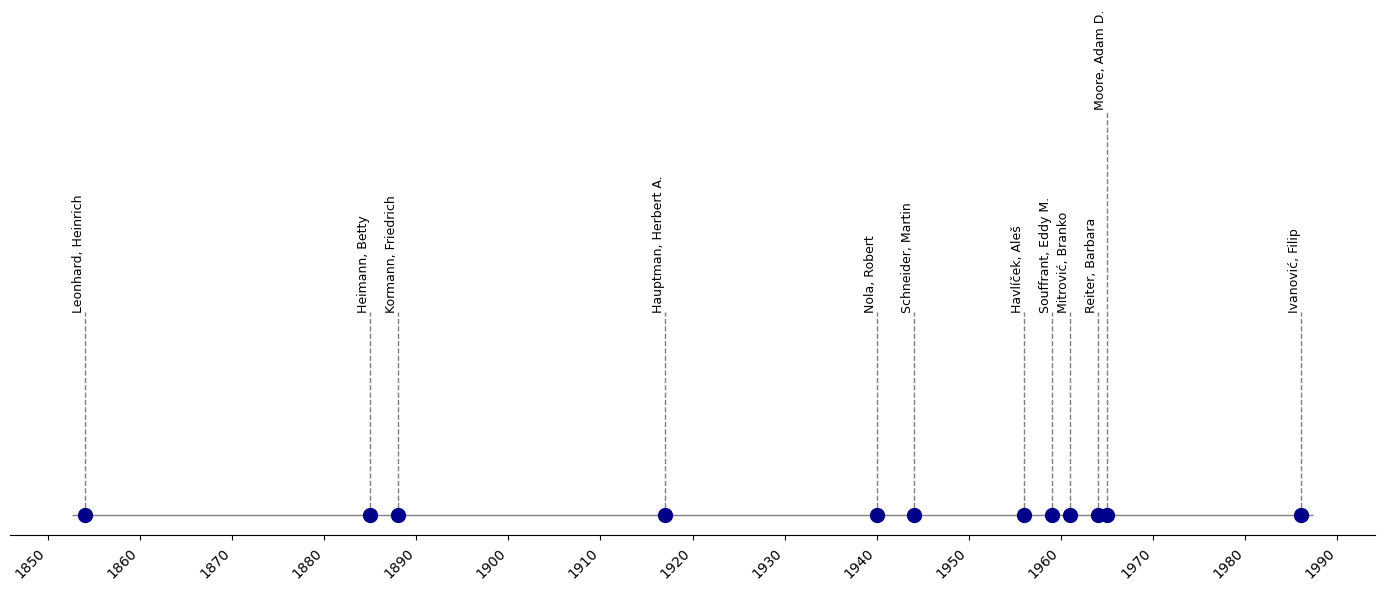

In [ ]:
# some example data
#dates = ['1888-06-13', '1950-01-01', '1959-03-26', '1854-07-29', '1854-07-29',
#         '1940-06-25', '1888-01-01', '1950-01-01', '1961-09-28', '1961-09-28']
#names = ['Paquette, Elisabeth', 'Pitts, Andrea J.', 'Souffrant, Eddy M.',
#         'Leonhard, Heinrich', 'Wiehart, Alexander', 'Nola, Robert',
#         'Kormann, Friedrich', 'Woody, Andrea', 'Mitrović, Branko', 'Speidel, Markus']

show_simple_timeline(dates, names)

### STEP 7: Make data available as csv

In [ ]:
from google.colab import files
import pandas as pd
df = pd.DataFrame(merged_items)
df.to_csv('WikidataPlusGndData.csv')
files.download('WikidataPlusGndData.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## WORKFLOW 2 (Use nexus_py)
You can find the code for nexus_py in SETUP STEP 5.

1. query Wikidata with SPARQL
2. initialise Nexus
3. aggregate data with Nexus
4. visualise data
5. download data

### STEP 1 (!): SPARQL + refinement (define our set of items/entities)

We can build our SPARQL query in the [Wikidata Query Service](https://query.wikidata.org/) and then copy & paste the triples into our code cell below.
Use https://www.wikidata.org to look for properties and entities you would like to use.

#### Cheat Sheet:


* some examples for occupations (P106):
  * philosopher: Q4964182
  * chemist: Q593644
  * writer: Q36180

* the parts of this example:
  * is a human: wdt:P31 wd:Q5
  * occupation is philosopher: wdt:P106 wd:Q4964182
  * has a PhD: wdt:P512 wd:Q752297
  * has a link to the GND: wdt:P227 ?gnd_id

#### STEP 1.1 (!): Let's define our triples:
* should start with "?item" as our subject
* each element should be delimited by a blank space
* should end with a "." (dot)
* each predicate + object pair (but the first) has to be appended with a ";" (semicolon)

In [ ]:
sparql_query_triples = "?item wdt:P31 wd:Q5 ; wdt:P106 wd:Q4964182 ; wdt:P512 wd:Q752297 ; wdt:P227 ?gnd_id ."

# put it all together
sparql_query = sparql_query_prefix + sparql_query_triples + sparql_query_suffix

# check if the query looks as intended
print(sparql_query)

SELECT DISTINCT ?item ?gnd_id ?viaf_id ?label_en ?label_de ?label_fr ?label_it ?label_pt (year(?birth_date) as ?birth_year) (year(?death_date) as ?death_year)
WHERE
{
  ?item wdt:P31 wd:Q5 ; wdt:P106 wd:Q4964182 ; wdt:P512 wd:Q752297 ; wdt:P227 ?gnd_id .
  OPTIONAL {?item wdt:P227 ?gnd_id.}
  OPTIONAL {?item wdt:P214 ?viaf_id.}
  OPTIONAL {?item wdt:P569 ?birth_date.}
  OPTIONAL {?item wdt:P570 ?death_date.}
  OPTIONAL {?item rdfs:label ?label_en filter (lang(?label_en) = "en").}
  OPTIONAL {?item rdfs:label ?label_de filter (lang(?label_de) = "de").}
  OPTIONAL {?item rdfs:label ?label_fr filter (lang(?label_fr) = "fr").}
  OPTIONAL {?item rdfs:label ?label_it filter (lang(?label_it) = "it").}
  OPTIONAL {?item rdfs:label ?label_pt filter (lang(?label_pt) = "pt").}
}


#### STEP 1.2 (!): Send query to Wikidata and count returned items
This does the HTTP request for us using our SPARQL query and gives us a short feedback (shows count of returned items).

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('send SPARQL query to Wikidata...(and get all humans who are occupied as philosopher and have a PhD)')
print('### ### ### ### ### ### ### ### ### ###')
from qwikidata.sparql import (get_subclasses_of_item, return_sparql_query_results)
import urllib.request, json

def fetch_entities_from_wikidata():
# does the HTTP request and returns query response (in a nice way)
    return return_sparql_query_results(sparql_query)

# make bindings (i.e. wanted results of the query) available in other code cells
items = (fetch_entities_from_wikidata()["results"]["bindings"])
print('Items count: ' + str(len(items)))

### ### ### ### ### ### ### ### ### ###
send SPARQL query to Wikidata...(and get all humans who are occupied as philosopher and have a PhD)
### ### ### ### ### ### ### ### ### ###
Items count: 450


#### STEP 1.3: Get a more detailed feedback by highlighting a random item.

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('choose a random item...')
print('### ### ### ### ### ### ### ### ### ###')

import random

print('items count: ' + str(len(items)))
randomItemNr = random.randint(0, len(items)-1) # get random number within scope
print('Random item (' + str(randomItemNr) + '):')
print(items[randomItemNr])
randomItem = items[randomItemNr] # get random entity
if 'label_en' in randomItem:
  print(randomItem['item']['value'].split('/')[-1] + ' = ' + randomItem['label_en']['value'])

# make entity's Wikidata ID available in other code cells
randomItemQID = (randomItem['item']['value'].split('/')[-1])


### ### ### ### ### ### ### ### ### ###
choose a random item...
### ### ### ### ### ### ### ### ### ###
items count: 450
Random item (405):
{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q6548051'}, 'label_it': {'xml:lang': 'it', 'type': 'literal', 'value': 'Lilli Alanen'}, 'label_fr': {'xml:lang': 'fr', 'type': 'literal', 'value': 'Lilli Alanen'}, 'label_de': {'xml:lang': 'de', 'type': 'literal', 'value': 'Lilli Alanen'}, 'label_en': {'xml:lang': 'en', 'type': 'literal', 'value': 'Lilli Alanen'}, 'gnd_id': {'type': 'literal', 'value': '143605194'}, 'viaf_id': {'type': 'literal', 'value': '133538'}, 'birth_year': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '1941'}, 'death_year': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '2021'}}
Q6548051 = Lilli Alanen


#### STEP 1.4 (!): Refinement and deduplication (execute after each new query)
This will clean up our set of items.
* Throw out items without en, de, fr, it, pt labels
* Pick only the first appearance of an items (deduplication)

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('do some refinement on the list of items...(deduplication and sorting out entities without labels...)')
print('### ### ### ### ### ### ### ### ### ###')

items_cleaned = refine_items(items)

### ### ### ### ### ### ### ### ### ###
do some refinement on the list of items...(deduplication and sorting out entities without labels...)
### ### ### ### ### ### ### ### ### ###
do refine wikidata exports, e.g. convert URIs into Qs
The first 10 entries are:
['Q100428034', '1221604929', '11158912149049770336', 'Elisabeth Paquette', 'Elisabeth Paquette', 'Elisabeth Paquette', 'Elisabeth Paquette', 'Elisabeth Paquette', '', '']
['Q100699312', '1190767597', '317108092', 'Andrea J. Pitts', '', '', 'Andrea J. Pitts', '', '', '']
['Q100745230', '1103835785', '28870973', 'Eddy Souffrant', '', '', '', '', '', '']
['Q102246200', '1014901588', '176876582', 'Heinrich Leonhard', 'Heinrich Leonhard', '', '', '', '1854', '1942']
['Q104813936', '114574065', '433159474351027662917', 'Alexander Wiehart', 'Alexander Wiehart', 'Alexander Wiehart', 'Alexander Wiehart', '', '', '']
['Q105243708', '151537305', '32050061', 'Robert Nola', 'Robert Nola', 'Robert Nola', '', '', '1940', '2022']
['Q105274874', 

#### STEP 1.5: Get a more detailed feedback by highlighting a random item again.
(You can click the links to look it up in Wikidata or the GND Explorer.)

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('choose a random item...again')
print('### ### ### ### ### ### ### ### ### ###')

import random

print('Items count: ' + str(len(items_cleaned)))
randomItemNr = random.randint(0, len(items_cleaned)-1) # get random number within scope
print('Random item (' + str(randomItemNr) + '):')
print(items_cleaned[randomItemNr])
randomItem = items_cleaned[randomItemNr] # get random entity

# make entity's Wikidata ID available in other code cells
randomItemQID = (randomItem[0])
print('Wikidata-ID: ' + randomItemQID + ' (cf. Wikidata: https://www.wikidata.org/wiki/Special:EntityData/' + randomItemQID + ')')

# make entity's Wikidata ID available in other code cells
randomItemGNDID = (randomItem[1])
print('GND-ID: ' + randomItemGNDID + ' (cf. GND Explorer: https://explore.gnd.network/gnd/' + randomItemGNDID + ')')

### ### ### ### ### ### ### ### ### ###
choose a random item...again
### ### ### ### ### ### ### ### ### ###
Items count: 422
Random item (124):
['Q1875029', '122199561', '263342690', 'Ludwig Siep', 'Ludwig Siep', 'Ludwig Siep', 'Ludwig Siep', 'Ludwig Siep', '1942', '']
Wikidata-ID: Q1875029 (cf. Wikidata: https://www.wikidata.org/wiki/Special:EntityData/Q1875029)
GND-ID: 122199561 (cf. GND Explorer: https://explore.gnd.network/gnd/122199561)


### STEP 2: Initialise Nexus

##### STEP 2.1: Load mappings (execute after modifying mappings)

In [ ]:
mappings_json = json.loads(nexus_mappings_json)
mappings_schema_json = json.loads(nexus_mappings_schema_json)

##### STEP 2.2: Initialise new Nexus object

In [ ]:
# instantiate an object of the class "Nexus":
# it can do all the steps we did so far (but it's still work in progress)
my_nexus = Nexus()

### STEP 3: Use Nexus to aggregate data

#### STEP 3.1: Let's give it a try with some test cases

In [ ]:


my_nexus_aggregation_flat_kant = my_nexus.get_aggregation_flat(mappings_json,
                                                          mappings_schema_json,
                                                          'person',
                                                           {'Wikidata': 'Q9312',
                                                            'GND': '118559796',
                                                            'LCNAF': 'n79021614',
                                                            'VIAF': '82088490'}
                                                          ) # Immanuel Kant

print(my_nexus_aggregation_flat_kant)

my_nexus_aggregation_flat_pessoa = my_nexus.get_aggregation_flat(mappings_json,
                                                          mappings_schema_json,
                                                          'person',
                                                           {'Wikidata': 'Q173481',
                                                            'GND': '118740113',
                                                            'LCNAF': 'n50016857',
                                                            'VIAF': '126144814444407525004'}
                                                          ) # Fernando Pessoa

print(my_nexus_aggregation_flat_pessoa)

{'wikidata_id': 'Q9312', 'gnd_id': '118559796', 'preferred_name': 'Kant, Immanuel', 'birth_date': '1724-04-22', 'birth_place': 'Königsberg', 'death_date': '1804-02-12', 'death_place': 'Königsberg'}
{'wikidata_id': 'Q173481', 'gnd_id': '118740113', 'preferred_name': 'Pessoa, Fernando', 'birth_date': '1888-06-13', 'birth_place': 'Lissabon', 'death_date': '1935-11-30', 'death_place': 'Lissabon'}


#### STEP 3.2: Use nexus_py for our list of items

In [ ]:
my_aggregations_flat = []

n = 10 # get only the first 10 items from list
items_subset = items_cleaned[0:n]

for item in items_subset:
  #print(item)
  if item[2] != '':
    # for this item we can use VIAF as an additional resource
    my_aggregation_flat = my_nexus.get_aggregation_flat(mappings_json,
                                                     mappings_schema_json,
                                                     'person',
                                                      {'Wikidata': item[0],
                                                       'GND': item[1],
                                                       'VIAF': item[2]}
                                                     )
  else:
    # no VIAF ID, so don't use VIAF
    my_aggregation_flat = my_nexus.get_aggregation_flat(mappings_json,
                                                     mappings_schema_json,
                                                     'person',
                                                      {'Wikidata': item[0],
                                                       'GND': item[1]}
                                                     )
  #print(my_aggregation_flat)
  my_aggregations_flat.append(my_aggregation_flat)

print(len(my_aggregations_flat))

10


### STEP 4: Make a visualisation again

##### STEP 4.1: Get birth_date and preferred_name

In [ ]:
dates = []
names = []

for item in my_aggregations_flat:
  item_date = item['birth_date']
  # this is a bit dirty, but we will need to fix some dates:
  # we need to limit the dates we visualise to "after 1680"
  # due to limitations in pandas (Python package)
  if(int(item_date[0:4])>1680):
    if len(item_date)==4:
      item_date = item_date + '-01-01'
    item_date = item_date.replace('[', '')
    item_date = item_date.replace(']', '')
    item_date = item_date.replace('X', '0')
    dates.append(str(item_date))
    names.append(item['preferred_name'])


##### STEP 4.2: Do something with our data => visualise birth_date as timeline

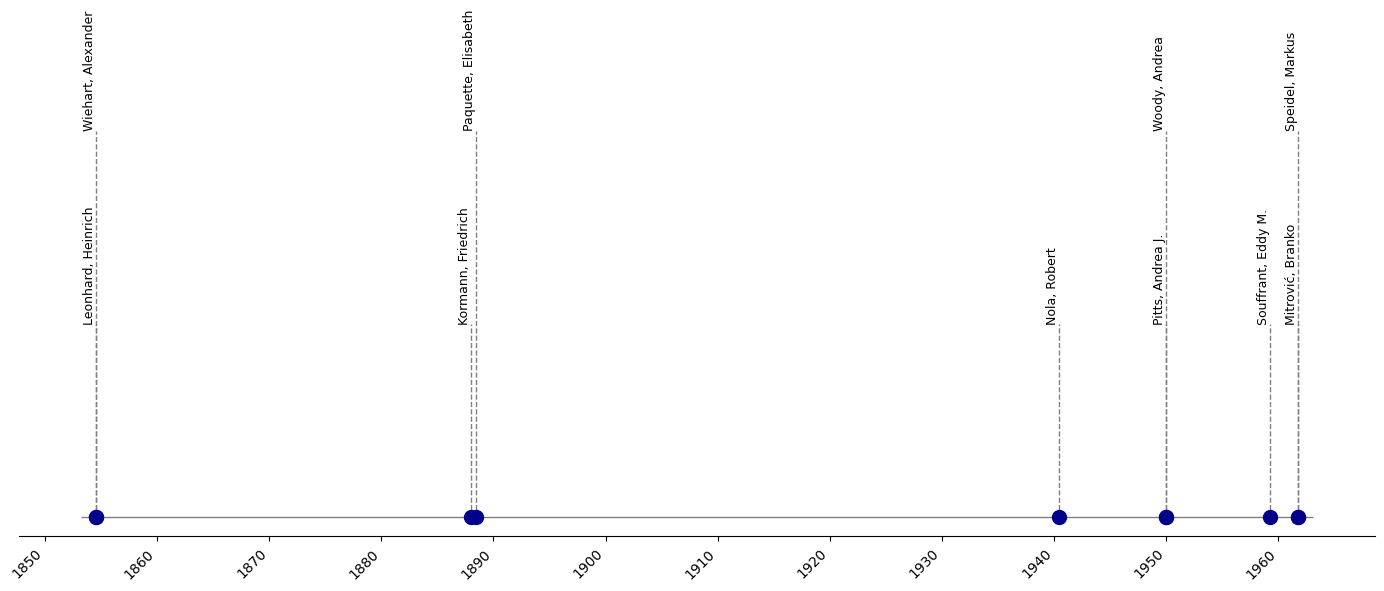

In [ ]:
# some example data
#dates = ['1888-06-13', '1950-01-01', '1959-03-26', '1854-07-29', '1854-07-29',
#         '1940-06-25', '1888-01-01', '1950-01-01', '1961-09-28', '1961-09-28']
#names = ['Paquette, Elisabeth', 'Pitts, Andrea J.', 'Souffrant, Eddy M.',
#         'Leonhard, Heinrich', 'Wiehart, Alexander', 'Nola, Robert',
#         'Kormann, Friedrich', 'Woody, Andrea', 'Mitrović, Branko', 'Speidel, Markus']

show_simple_timeline(dates, names)

### STEP 5: Download data as csv

In [ ]:
from google.colab import files
import pandas as pd
df = pd.DataFrame(my_aggregations_flat)
df.to_csv('NexusData.csv')
files.download('NexusData.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### BONUS LEVEL / FAST LANE (in case you only want to get data from Wikidata

## WORKFLOW 3 (Wikdiata only)

If we only want data from Wikidata and no other source: this will be the fastest way.

1. query Wikidata with SPARQL
2. visualise data
3. download data


### STEP 1 (!): SPARQL + refinement (define our set of items/entities)

We can build our SPARQL query in the [Wikidata Query Service](https://query.wikidata.org/) and then copy & paste the triples into our code cell below.
Use https://www.wikidata.org to look for properties and entities you would like to use.

#### Cheat Sheet:


* some examples for occupations (P106):
  * philosopher: Q4964182
  * chemist: Q593644
  * writer: Q36180

* the parts of this example:
  * is a human: wdt:P31 wd:Q5
  * occupation is philosopher: wdt:P106 wd:Q4964182
  * has a PhD: wdt:P512 wd:Q752297
  * has a link to the GND: wdt:P227 ?gnd_id

#### STEP 1.1 (!): Let's define our triples:
* should start with "?item" as our subject
* each element should be delimited by a blank space
* should end with a "." (dot)
* each predicate + object pair (but the first) has to be appended with a ";" (semicolon)

In [ ]:
sparql_query="""
SELECT DISTINCT ?item ?gnd_id ?viaf_id ?label_en ?label_de ?label_fr ?label_it ?label_pt (year(?birth_date) as ?birth_year) (year(?death_date) as ?death_year)
WHERE
{
  ?item wdt:P31 wd:Q5 ;
  wdt:P106 wd:Q4964182 ;
  wdt:P512 wd:Q752297 ;
  wdt:P227 ?gnd_id ;
  wdt:P569 ?birth_date ;
  rdfs:label ?label_en filter (lang(?label_en) = "en") .
  OPTIONAL {?item wdt:P227 ?gnd_id.}
  OPTIONAL {?item wdt:P214 ?viaf_id.}
  OPTIONAL {?item wdt:P569 ?birth_date.}
  OPTIONAL {?item wdt:P570 ?death_date.}
  OPTIONAL {?item rdfs:label ?label_en filter (lang(?label_en) = "en").}
  OPTIONAL {?item rdfs:label ?label_de filter (lang(?label_de) = "de").}
  OPTIONAL {?item rdfs:label ?label_fr filter (lang(?label_fr) = "fr").}
  OPTIONAL {?item rdfs:label ?label_it filter (lang(?label_it) = "it").}
  OPTIONAL {?item rdfs:label ?label_pt filter (lang(?label_pt) = "pt").}
}
"""

# check if the query looks as intended
print(sparql_query)


SELECT DISTINCT ?item ?gnd_id ?viaf_id ?label_en ?label_de ?label_fr ?label_it ?label_pt (year(?birth_date) as ?birth_year) (year(?death_date) as ?death_year)
WHERE
{
  ?item wdt:P31 wd:Q5 ;
  wdt:P106 wd:Q4964182 ;
  wdt:P512 wd:Q752297 ;
  wdt:P227 ?gnd_id ;
  wdt:P569 ?birth_date ;
  rdfs:label ?label_en filter (lang(?label_en) = "en") .
  OPTIONAL {?item wdt:P227 ?gnd_id.}
  OPTIONAL {?item wdt:P214 ?viaf_id.}
  OPTIONAL {?item wdt:P569 ?birth_date.}
  OPTIONAL {?item wdt:P570 ?death_date.}
  OPTIONAL {?item rdfs:label ?label_en filter (lang(?label_en) = "en").}
  OPTIONAL {?item rdfs:label ?label_de filter (lang(?label_de) = "de").}
  OPTIONAL {?item rdfs:label ?label_fr filter (lang(?label_fr) = "fr").}
  OPTIONAL {?item rdfs:label ?label_it filter (lang(?label_it) = "it").}
  OPTIONAL {?item rdfs:label ?label_pt filter (lang(?label_pt) = "pt").}
}



#### STEP 1.2 (!): Send query to Wikidata and count returned items
This does the HTTP request for us using our SPARQL query and gives us a short feedback (shows count of returned items).

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('send SPARQL query to Wikidata...(and get all humans who are occupied as philosopher and have a PhD)')
print('### ### ### ### ### ### ### ### ### ###')
from qwikidata.sparql import (get_subclasses_of_item, return_sparql_query_results)
import urllib.request, json

def fetch_entities_from_wikidata():
# does the HTTP request and returns query response (in a nice way)
    return return_sparql_query_results(sparql_query)

# make bindings (i.e. wanted results of the query) available in other code cells
items = (fetch_entities_from_wikidata()["results"]["bindings"])
print('Items count: ' + str(len(items)))

### ### ### ### ### ### ### ### ### ###
send SPARQL query to Wikidata...(and get all humans who are occupied as philosopher and have a PhD)
### ### ### ### ### ### ### ### ### ###
Items count: 425


#### STEP 1.3: Get a more detailed feedback by highlighting a random item.

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('choose a random item...')
print('### ### ### ### ### ### ### ### ### ###')

import random

print('items count: ' + str(len(items)))
randomItemNr = random.randint(0, len(items)-1) # get random number within scope
print('Random item (' + str(randomItemNr) + '):')
print(items[randomItemNr])
randomItem = items[randomItemNr] # get random entity
if 'label_en' in randomItem:
  print(randomItem['item']['value'].split('/')[-1] + ' = ' + randomItem['label_en']['value'])

# make entity's Wikidata ID available in other code cells
randomItemQID = (randomItem['item']['value'].split('/')[-1])


### ### ### ### ### ### ### ### ### ###
choose a random item...
### ### ### ### ### ### ### ### ### ###
items count: 425
Random item (389):
{'item': {'type': 'uri', 'value': 'http://www.wikidata.org/entity/Q105243708'}, 'label_en': {'xml:lang': 'en', 'type': 'literal', 'value': 'Robert Nola'}, 'gnd_id': {'type': 'literal', 'value': '151537305'}, 'viaf_id': {'type': 'literal', 'value': '32050061'}, 'birth_year': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '1940'}, 'label_fr': {'xml:lang': 'fr', 'type': 'literal', 'value': 'Robert Nola'}, 'label_de': {'xml:lang': 'de', 'type': 'literal', 'value': 'Robert Nola'}, 'death_year': {'datatype': 'http://www.w3.org/2001/XMLSchema#integer', 'type': 'literal', 'value': '2022'}}
Q105243708 = Robert Nola


#### STEP 1.4 (!): Refinement and deduplication (execute after each new query)
This will clean up our set of items.
* Throw out items without en, de, fr, it, pt labels
* Pick only the first appearance of an items (deduplication)

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('do some refinement on the list of items...(deduplication and sorting out entities without labels...)')
print('### ### ### ### ### ### ### ### ### ###')

items_cleaned = refine_items(items)

### ### ### ### ### ### ### ### ### ###
do some refinement on the list of items...(deduplication and sorting out entities without labels...)
### ### ### ### ### ### ### ### ### ###
do refine wikidata exports, e.g. convert URIs into Qs
The first 10 entries are:
['Q102246200', '1014901588', '176876582', 'Heinrich Leonhard', 'Heinrich Leonhard', '', '', '', '1854', '1942']
['Q105243708', '151537305', '32050061', 'Robert Nola', 'Robert Nola', 'Robert Nola', '', '', '1940', '2022']
['Q105274874', '1116983524', '267767035', 'Friedrich Kormann', 'Friedrich Kormann', '', '', '', '1888', '']
['Q106367208', '130868825', '47063491', 'Branko Mitrović', 'Branko Mitrovic', 'Branko Mitrovic', '', 'Branko Mitrovic', '1961', '']
['Q107407179', '128876948', '279790626', 'Martin Schneider', 'Martin Schneider', 'Martin Schneider', 'Martin Schneider', 'Martin Schneider', '1944', '']
['Q107422', '123570913', '84823339', 'Herbert A. Hauptman', 'Herbert A. Hauptman', 'Herbert Aaron Hauptman', 'Herbert Hauptma

#### STEP 1.5: Get a more detailed feedback by highlighting a random item again.
(You can click the links to look it up in Wikidata or the GND Explorer.)

In [ ]:
print('### ### ### ### ### ### ### ### ### ###')
print('choose a random item...again')
print('### ### ### ### ### ### ### ### ### ###')

import random

print('Items count: ' + str(len(items_cleaned)))
randomItemNr = random.randint(0, len(items_cleaned)-1) # get random number within scope
print('Random item (' + str(randomItemNr) + '):')
print(items_cleaned[randomItemNr])
randomItem = items_cleaned[randomItemNr] # get random entity

# make entity's Wikidata ID available in other code cells
randomItemQID = (randomItem[0])
print('Wikidata-ID: ' + randomItemQID + ' (cf. Wikidata: https://www.wikidata.org/wiki/Special:EntityData/' + randomItemQID + ')')

# make entity's Wikidata ID available in other code cells
randomItemGNDID = (randomItem[1])
print('GND-ID: ' + randomItemGNDID + ' (cf. GND Explorer: https://explore.gnd.network/gnd/' + randomItemGNDID + ')')

### ### ### ### ### ### ### ### ### ###
choose a random item...again
### ### ### ### ### ### ### ### ### ###
Items count: 400
Random item (45):
['Q124505', '118752588', '108231384', 'Emil Staiger', 'Emil Staiger', 'Emil Staiger', 'Emil Staiger', 'Emil Staiger', '1908', '1987']
Wikidata-ID: Q124505 (cf. Wikidata: https://www.wikidata.org/wiki/Special:EntityData/Q124505)
GND-ID: 118752588 (cf. GND Explorer: https://explore.gnd.network/gnd/118752588)


### STEP 2: Make a simple timeline

#### STEP 2.1: Get dates and names (sort out items with difficult dates)

Note:
Sadly "pandas" (which we are using in Python) can only handle dates after 1677.

(cf. https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#timestamp-limitations)

In [ ]:
dates = []
names = []

for item in items_cleaned:
  # we need to limit the dates we visualise to "after 1680"
  # due to limitations in pandas (Python package)
  if(int(item[8])>1680):
    dates.append(str(item[8])) # birth_date
    names.append(item[3]) # label_en

#### STEP 2.2: Visualise => plot timeline

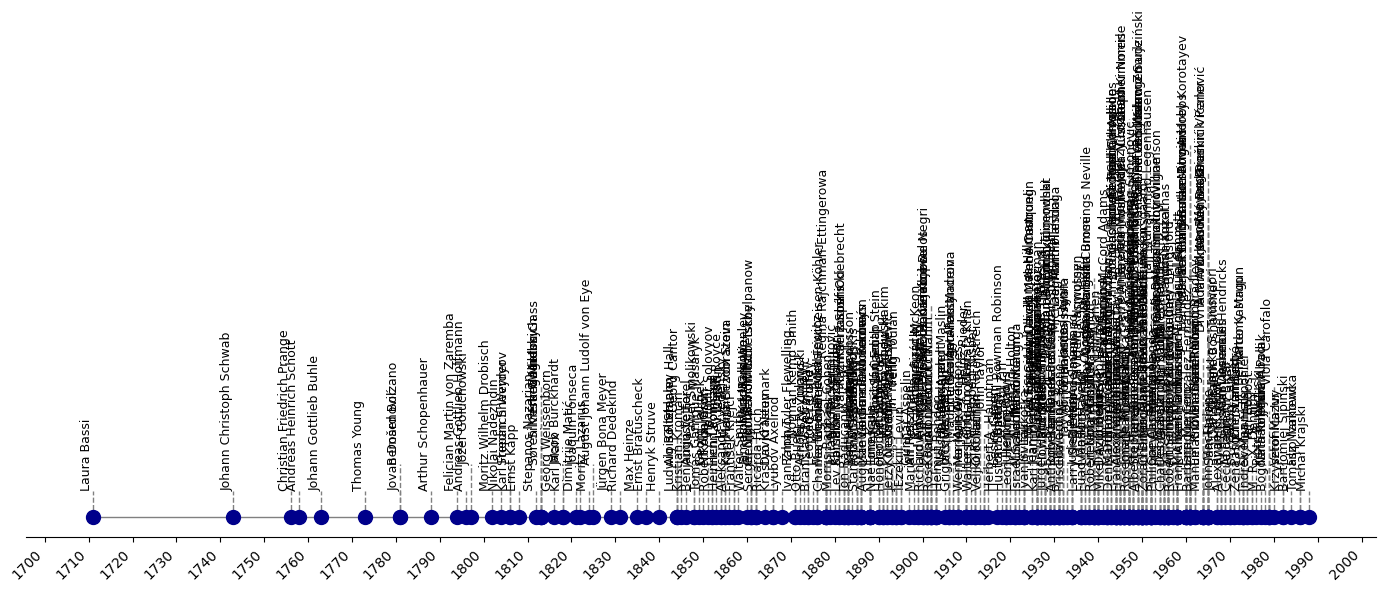

In [ ]:
# some example data
#dates = ['1888-06-13', '1950-01-01', '1959-03-26', '1854-07-29', '1854-07-29',
#         '1940-06-25', '1888-01-01', '1950-01-01', '1961-09-28', '1961-09-28']
#names = ['Paquette, Elisabeth', 'Pitts, Andrea J.', 'Souffrant, Eddy M.',
#         'Leonhard, Heinrich', 'Wiehart, Alexander', 'Nola, Robert',
#         'Kormann, Friedrich', 'Woody, Andrea', 'Mitrović, Branko', 'Speidel, Markus']

show_simple_timeline(dates, names)

### STEP 3: Download data as csv

In [ ]:
from google.colab import files
import pandas as pd
df = pd.DataFrame(items_cleaned)
df.to_csv('WikidataOnlyData.csv')
files.download('WikidataOnlyData.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Some additional notes...

### Some notes...

#### About using Wikidata
* When we look into an entity in Wikidata (e.g. Immanuel Kant: https://www.wikidata.org/wiki/Q9312) of a certain type (e.g. person), we can easily look up and pick the fields/properties we're interested in.
* Wikidata properties start with a capital "P" and have a number (e.g. P569 (date of birth) https://www.wikidata.org/wiki/Property:P569), whereas entities start with a capital "Q" (e.g. Q9312 (Immanuel Kant) https://www.wikidata.org/wiki/Q9312).
* We get our (machine-readable) data from Wikidata in two ways:
  * Via its SPARQL endpoint. => Make a set of entities we want to know more about, get their Wikidata IDs. This can take some time (and will timeout at somewhere above 20 seconds), if the query is too complex or too wide.
  * Via its Linked Data Interface (see https://www.wikidata.org/wiki/Wikidata:Data_access#Linked_Data_Interface_(URI) for details). => Get the details/properties of a certain entity, but we need its Wikidata ID first. (e.g. https://www.wikidata.org/wiki/Special:EntityData/Q9312.json)
* There is a special type of property (cf. https://www.wikidata.org/wiki/Wikidata:External_identifiers ...and there's a long list https://www.wikidata.org/w/index.php?title=Special:ListProperties/external-id&limit=500&offset=0, too) which refers to the same entity on another website or another knowledge base.
* Some of those other knowledge bases are authority files.

#### About using other data sources
* Some of those aforementioned external data sources are knowledge bases themselves.
* Some others are websites like e.g. https://plato.stanford.edu/entries/kant/ (P3123, linking to the Stanford Encyclopedia of Philosophy, a peer-reviewed resource).
* The sources that are knowledge bases we can handle like Wikidata (mostly).
* Knowledge bases usually provide us with an overview of what we can find in there and how to obtain it (e.g. the Gemeinsame Normdatei (GND), which is the German authority file provided by the DNB: https://d-nb.info/standards/elementset/gnd).

#### About using Insomnia
* JSONPath and XPath give us the ability to select/access fields within the JSON or XML output without writing a specific algorithm.
* We can use Insomnia (https://insomnia.rest/download) to build such JSONPath and XPath manually. For XPath Oxygen (https://www.oxygenxml.com/) can be an alternative, which is often used in XML-heavy DH projects.
* You might even try to ask a chatbot AI to give you such a path.